In [1]:
from nanodrivers.non_visa_drivers.Dig_Attenuator import DigAtt
from nanodrivers.visa_drivers.lockin import LOCKIN
from nanodrivers.visa_drivers.FFT_SA import Din_SA
from nanodrivers.visa_drivers.anapico import ANAPICO
from nanodrivers.visa_drivers.dc import DC
from nanodrivers.visa_drivers.vna import VNA
from nanodrivers.visa_drivers.AWG import AWG
import pyvisa

#math
import numpy as np
from numpy import *
from scipy.optimize import curve_fit

#plotting
import matplotlib.pyplot as plt
import matplotlib

#matlab import
import scipy.io
from scipy.io import savemat

#file_store
import os
import copy

#time
from datetime import datetime, timedelta
import time

from ctypes import *
%matplotlib inline


# Some general functions needed
def linear_func(x, a, b):
    return a * x + b

def linear_fit(x, y):
    popt, pcov = curve_fit(linear_func, x, y)
    a = popt[0]
    b = popt[1]
    return a, b
    
def db2pow(db):
    return 10*np.log10(db)

C:\Users\Demag\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Connect all devises
After the section was run an object of device appears. After this all commands could be applied to this object if the way of Obj.command(args)

In [2]:
loking = LOCKIN(device_address = 'GPIB0::30::INSTR')
loking.idn()

Connection exist: Stanford_Research_Systems,SR844,s/n48867,ver1.006



In [4]:
# The connection is established via LAN. So far I made it to drop connection after some time, but still sometimes
# after kernell has been restarted AnaPico stays busy. To resolve it, one need to remove AnaPico from Ni MAX list
# If it doesn't help, turn of output with application and power cycle the device. 
anapico = ANAPICO()
anapico.idn()

Connection exist: AnaPico AG,APMS20G,3C6-0B4F40003-0985,0.4.209



In [5]:
# anapico.close()

In [6]:
rm = pyvisa.ResourceManager()
awg = rm.open_resource('GPIB0::12::INSTR')
awg.query('*IDN?')

'Agilent Technologies,33510B,MY52200739,3.03-1.19-2.00-52-00\n'

In [5]:
# dc.query('VOLT:OFFS?')
# awg.query('OUTP1?')
loking.get_sensitivity()

10.0

In [6]:
DigAtt = DigAtt()
DigAtt.set_att(6, 0)

0

In [7]:
DigAtt.set_att(3.8, 0)

0

# Base parameters

In [7]:
now = datetime.now()  
state=dict()

f_res4 =  5.77797
state['f_res4'] = f_res4

# Get single error function

In [12]:
anapico.off(3)
awg.write('OUTPUT1 OFF')

13

In [60]:
def get_phase_guess():
    '''
    
    This function is ment to find point where Y component is about 0. 
    It sweeps phase untill the Y sign doesn't change, then chenges step size and repeat it again.
    
    Returns: best_pha, loking.get_Y_data()
    
    '''

    def find_min(d):
        '''
        
        This function finds minimum of Y component
        Args: 
            d: step of the phase while looking for minimum
        
        Returns: best_pha
        
        '''
        
        #     anapico.set_freq(3, f_res4*1e9)
        
        initial_phase = loking.get_phase()
        i = 0
        while abs(initial_phase)<0.005 and i<10:
            i+=1
            time.sleep(1)
            initial_phase = loking.get_phase()
        
        current_phase = copy.deepcopy(initial_phase)
        
        t = loking.get_Y_data()
        t = loking.get_Y_data()
        initial_Y_guess = loking.get_Y_data()
        current_Y_guess = loking.get_Y_data()
        
        
        if initial_Y_guess>0: delta = d
        else: delta = -d
        
        phases = np.array([])
        y_phase_sweep = np.array([])
        
        i = 0
        while np.sign(initial_Y_guess) == np.sign(current_Y_guess) and i<360:
            i+=1
            current_phase = current_phase+delta
            loking.set_phase(np.round(current_phase,2))
            phases = np.append(phases, current_phase)
            current_Y_guess = loking.get_Y_data()
            y_phase_sweep = np.append(y_phase_sweep, current_Y_guess)

        y_phase_sweep_abs = abs(y_phase_sweep)     # finds abs of Y component so that min would be closest to 0
        
        if len(y_phase_sweep_abs)>1:
            index = np.where(y_phase_sweep_abs==min(y_phase_sweep_abs))[0][0] # finds index of min element

            best_pha = phases[index]    # gets corresponding phase
            loking.set_phase(best_pha)  # sets this phsase to locking
        else: 
            best_pha = initial_phase
            loking.set_phase(best_pha)
            
        return best_pha
    

    
    time.sleep(3)
    best_pha = find_min(1)                   # Step is 1 deg
    loking.set_phase(np.round(best_pha,2))
    time.sleep(3)
    best_pha = find_min(0.5)                 # Step is 0.5 deg
    loking.set_phase(np.round(best_pha,2))
    time.sleep(3)
    best_pha = find_min(0.1)                 # Step is 0.1 deg
    loking.set_phase(np.round(best_pha,2))
    time.sleep(3)
    best_pha = find_min(0.01)                # Step is 0.01 deg
    loking.set_phase(np.round(best_pha,2))
    time.sleep(3)
    best_pha = find_min(0.01)                # Step is 0.01 deg
    loking.set_phase(np.round(best_pha,2))
    
    return best_pha, loking.get_Y_data()

        
    
def get_epsilon(offset, avg, nop,f_res):
    '''
    This function is meant to find epsilon  as function of frequency
    
    Args: 
        offset:       sets the frequency sweep range limits
        avg:          number of sweep averaging
        nop:          number of sweep points
    Returns: 
        freq_y:       frequency range over which the epsilon sweep is made
        epsilon_mean: averaged epsilon function 
        a, b:         fit parameters of the epsilon linear part
        best_pha:     phase with 0 Y component
        
    '''
    
    freq_y = np.linspace(f_res-offset/1e6, f_res+offset/1e6, nop)  # sweep array
    anapico.set_freq(4, f_res*1e9)
    # best_pha, y = get_phase_guess() #find best phase
    # best_pha, y = get_phase_guess() #find best phase
    
    epsilon1 = np.empty((len(freq_y), avg))
    epsilon2 = np.empty((len(freq_y), avg)) 
    
    for i in range (len(freq_y)):
        anapico.set_freq(4, freq_y[i]*1e9)
        time.sleep(0.25)
        # time.sleep(0.5)
        for j in range(avg): 
            time.sleep(0.05)
            # time.sleep(0.1)
            epsilon1[i,j] = loking.get_X_data()
            epsilon2[i,j] = loking.get_Y_data()
            
    epsilon_mean1 = np.mean(epsilon1, axis=1)
    epsilon_mean2 = np.mean(epsilon2, axis=1)
    a, b = linear_fit(freq_y-f_res, epsilon_mean1)
    c, d = linear_fit(freq_y-f_res, epsilon_mean2)
    anapico.set_freq(4, f_res*1e9)
    return freq_y, epsilon_mean1, epsilon_mean2, a, b, c, d

# Get error function power sweep

In [90]:
# Set input signals
# %matplotlib qt
anapico.set_freq(3, f_res4*1e9)        # channel 3, freq = f_res4 GHz
anapow = 8
anapico.set_power(3, anapow)           # channel 3, power = 0 db
anapico.on(3)

avg_volt = 87
avg_f = 1.7315
awg.write('SOURCE1:VOLT {}'.format(avg_volt*1e-3))
awg.write('OUTPUT1 ON')
awg.write(r'SOUR{}:FREQ {}'.format(str(1), str(avg_f*1e6)))

22

In [10]:
DigAtt.set_att(f_res4, 0)
loking.set_phase(-106.57)

In [11]:
import numpy as np
asd = np.linspace(1,20,20)
IndexS = 5
IndexE = 10
print(asd)
for i in range(IndexS,IndexE):
    print(asd[i])

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20.]
6.0
7.0
8.0
9.0
10.0


In [14]:
anapico.set_freq(4, 5.77797*1e9)

In [96]:
DigAtt.set_att(5.77809, 15)

0

In [25]:
DigAtt.set_att(f_res4, 0)

0

22-28-18: Att 0 db, detuning index 0
22-30-05: Measurement done!


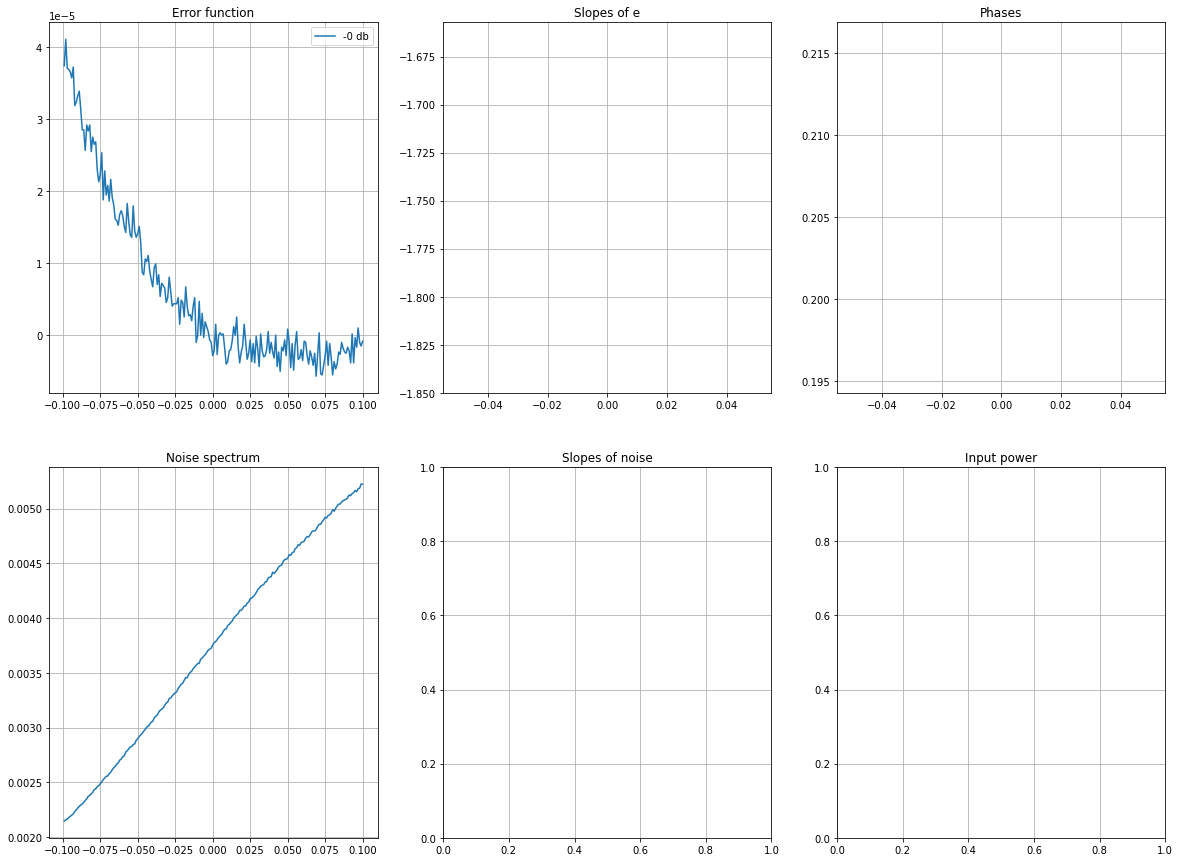

In [145]:
fig, ax = plt.subplots(2, 3, figsize=(20,15))
ax[0,0].set_title('Error function')
ax[0,1].set_title('Slopes of e')
ax[0,2].set_title('Phases')

ax[1,0].set_title('Noise spectrum')
ax[1,1].set_title('Slopes of noise')
ax[1,2].set_title('Input power')
ax[0,0].grid()
ax[0,1].grid()
ax[0,2].grid()
ax[1,0].grid()
ax[1,1].grid()
ax[1,2].grid()


now = datetime.now()  
folder = r'C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA\CoSi2_25nm_Shield'
# file = r'No_Cavity_Y_ErrPsw_0to10_'+ now.strftime(r'%H-%M-%S') + '.mat'
file = now.strftime(r'%Y%m%d%H%M%S') + r'_Poundlock_ERR'+ '.mat'
file_name = folder +'\\' + file

file_d = r'Y_ErrPsw_0to20_DUPLICATE_'+ now.strftime(r'%H-%M-%S') + '.mat'
file_name_d = folder +'\\' + file_d

# Attenuation
att_err = np.arange(0,1)  # Attenuation values. Seems like nothing to measure above 15 db
detuning = np.array([0])

# Epsilon function
# offset = 1000
# avg = 2 # 50
# nop = 201

offset = 100
avg = 2
nop = 201
epsilon1 = np.empty((nop,len(att_err),len(detuning)))
epsilon2 = np.empty((nop,len(att_err),len(detuning)))
slope1 = np.empty((len(att_err),len(detuning)))
amplitude1 = np.empty((len(att_err),len(detuning)))
slope2 = np.empty((len(att_err),len(detuning)))
amplitude2 = np.empty((len(att_err),len(detuning)))
pha_sweep = np.empty((len(att_err),len(detuning)))

gain = 10/(10e-3)

# Input power 
XY = np.empty((len(att_err),len(detuning)))

state=dict()
state['temp'] = 7.5
state['Gain'] = gain

state['att_err'] = att_err
state['epsilon1'] = epsilon1
state['epsilon2'] = epsilon2
state['slope_epsilon1'] = slope1
state['amplitude_epsilon1'] = amplitude1
state['slope_epsilon2'] = slope2
state['amplitude_epsilon2'] = amplitude2
state['pha_sweep'] = pha_sweep
state['att_err'] = att_err

# f_res4 = 5.77809+14e-3
f_res4 = 5.77793
# f_res4 = 5.77793+300e-6
# f_res4 = 5.77806-106/(1e6)
state['f_res4'] = f_res4


state['comment'] = 'CoSi 25 nm #4. Y component zero.'

for j in range(len(detuning)): 
    for at in range(len(att_err)): 
        f_res = f_res4+detuning[j]
        anapico.set_freq(4, f_res*1e9)
        # DigAtt.set_att(f_res, att_err[at]) # sets new attenuation
        print(datetime.now().strftime(r'%H-%M-%S:'), 'Att', att_err[at], 'db, detuning index', att_err[j])
        time.sleep(15) # wait until power would stabilize (at least 15 sec recommended)

        #get total input power 
        X0 = loking.get_X_data()
        X0 = loking.get_X_data()
        X0 = loking.get_X_data()
        Y0 = loking.get_Y_data()
        Y0 = loking.get_Y_data()
        Y0 = loking.get_Y_data()
        XY[at,j] = np.sqrt(X0**2+Y0**2)
        state['XY'] = XY

        # get epsilon sweep
        freq_y, epsilon_mean1, epsilon_mean2, a, b, c, d = get_epsilon(offset,avg,nop,f_res) # ret error function and slope (a)
        anapico.set_freq(4, f_res*1e9)
        # loking.set_phase(np.round(best_pha,2))

        # pha_sweep[at,j] = best_pha

        epsilon1[:,at,j] = epsilon_mean1
        epsilon2[:,at,j] = epsilon_mean2

        slope1[at,j] = a
        amplitude1[at,j] = b
        slope2[at,j] = c
        amplitude2[at,j] = d

        state['freq_y'] = freq_y
        state['pha_sweep'] = pha_sweep
        state['epsilon1'] = epsilon1
        state['epsilon2'] = epsilon2
        state['slope_epsilon1'] = slope1
        state['amplitude_epsilon1'] = amplitude1
        state['slope_epsilon2'] = slope2
        state['amplitude_epsilon2'] = amplitude2
        
        ax[0,0].plot((freq_y[1:]-f_res)*1000, epsilon_mean1[1:], label = '-{} db'.format(at))
        ax[1,0].plot((freq_y[1:]-f_res)*1000, epsilon_mean2[1:], label = '-{} db'.format(at))

        savemat(file_name, state)
        # savemat(file_name_d, state)
    
print(datetime.now().strftime(r'%H-%M-%S:'), 'Measurement done!')
    
ax[0,1].plot(np.arange(0,len(att_err)), np.log10(abs(slope1/10)))
ax[0,2].plot(np.arange(0,len(att_err)), np.log10(abs(slope2/10)))
# ax[1,1].plot(np.arange(0,len(att_err)), np.log10(abs(slope_fft/10)))
# ax[1,2].plot(np.arange(0,len(att_err)), np.log10(abs(XY/10)))
ax[0,0].legend()

# Manual

In [31]:
now = datetime.now()  
folder = r'C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA\CoSi\Open_loop\error_func\tmp'
file = r'Y_ErrPsw_0to20_manual'+ now.strftime(r'%H-%M-%S') + '.mat'
file_name = folder +'\\' + file

file_d = r'Y_ErrPsw_0to20_manual_DUPLICATE_'+ now.strftime(r'%H-%M-%S') + '.mat'
file_name_d = folder +'\\' + file_d

state=dict()
state['temp'] = 8.2

offset = 50 #kHz
freq_y = np.linspace(f_res4-offset/1e6, f_res4+offset/1e6, 100)
epsilon = np.empty((len(freq_y),len(att_err)))
slope = np.array([])
pha_sweep = np.array([])


state['att_err'] = att_err
state['epsilon'] = epsilon
state['slope_epsilon'] = slope
state['pha_sweep'] = pha_sweep
state['freq_y'] = freq_y
state['att_err'] = att_err

state['freq_y'] = freq_y
state['anapico_pow'] = anapow
state['modulation_v'] = avg_volt
state['f_res4'] = f_res4
state['comment'] = 'CoSi 25 nm #4. Previous measurements were done with X component in locking instead of Y'

gain = 10/(100*1e-6)

fft_avg = 300
state['fft_avg'] = fft_avg
fft_fr = dsa.get_freq()
state['fft_fr'] = fft_fr
err = np.empty((len(fft_fr),len(att_err)))
slope_fft = np.array([])
state['slope_fft'] = slope_fft


In [144]:
at = 14
DigAtt.set_att(f_res4, att_err[at]) # sets new attenuation

0

In [152]:
#get input power 
print('Start:', datetime.now().strftime(r'%H-%M-%S:'), 'new att', att_err[at], 'db')

state['sens'] = np.array([100e-6, 100e-6, 100e-6, 100e-6, 100e-6, 100e-6, 30e-6, 30e-6, 
                          30e-6, 30e-6, 30e-6, 10e-6, 10e-6, 3e-6, 3e-6])  # SET
current_phase = -146.94            # SET

pha_sweep = np.append(pha_sweep,current_phase)
state['pha_sweep'] = pha_sweep


X0 = loking.get_X_data()
Y0 = loking.get_Y_data()
XY = np.append(XY, np.sqrt(X0**2+Y0**2))
state['XY'] = XY

print('Start epsilon:', datetime.now().strftime(r'%H-%M-%S'))
freq_y, epsilon_mean, a, b = get_epsilon() # ret error function and slope (a)
epsilon[:,at] = epsilon_mean
state['epsilon'] = epsilon
slope = np.append(slope, a)
state['slope'] = slope

print('Start {} fft:'.format(fft_avg), datetime.now().strftime(r'%H-%M-%S'))
fft = dsa.read_d(avg=fft_avg) # get fft data with avg
err[:,at] = fft
state['err'] = err

start_fft = 4
stop_fft = -30
a, b = linear_fit(fft_fr[start_fft:stop_fft], fft[start_fft:stop_fft])
slope_fft = np.append(slope_fft, a)
state['slope_fft'] = slope_fft

savemat(file_name, state)
savemat(file_name_d, state)
print('Stop:', datetime.now().strftime(r'%H-%M-%S:'))

Start: 14-26-37: new att 14 db
Start epsilon: 14-26-37
Start 300 fft: 14-28-10
Stop: 15-12-27:


# Plot data

In [185]:
%matplotlib qt
fig, ax = plt.subplots(2, 4, figsize=(25,13))
plt.rcParams['axes.facecolor'] = 'white'
ax[0,0].set_title('Error function')
ax[0,1].set_title('Slopes of e')
ax[1,0].set_title('Noise spectrum')
ax[1,1].set_title('Slopes of noise')
ax[0,2].set_title('Phases')
ax[1,2].set_title('b offset in fft fit')
ax[0,3].set_title('Input_pow')
ax[0,2].set_yscale('log', base=10,)
ax[0,1].set_yscale('log', base=10,)
# ax[1,1].set_yscale('log', base=10,)
ax[0,2].grid()
ax[0,1].grid()
ax[0,0].grid()
ax[1,1].grid()
ax[1,0].grid()
ax[1,2].grid()
ax[0,3].grid()

start = 2
stop = -1
slopes_a = np.array([])
slopes_ff = np.array([])
b_ff = np.array([])
d = ((freq_y-f_res4)*1000)


for i in np.arange(0,6):
    
    ax[0,0].plot(d, epsilon[:,i], label = '-{} db'.format(att_err[i]))
    
    a, b = linear_fit(d[start:stop], epsilon[start:stop, i])
    slopes_a = np.append(slopes_a, a)
    ax[0,0].plot(d[start:stop], linear_func(d[start:stop], a, b), 'b', linewidth=0.5)
    
    c = slopes_a[i]
    c1 = np.log10(abs(slopes_a[i]))
    fft_pow = err[:,i]/10-c1
    
    ax[1,0].plot(np.log10(fft_fr[1:]), err[1:, i], label = '{}: -{} db'.format(i, att_err[i]))
    ax[1,1].plot(np.log10(fft_fr[1:]), fft_pow[1:], label = '{}: -{} db'.format(i, att_err[i]))
    
    a, b = linear_fit(np.log10(fft_fr[2:-90]), fft_pow[2:-90])
    slopes_ff = np.append(slopes_ff, a)
    b_ff = np.append(b_ff, b)
#     ax[1,1].plot(np.log10(fft_fr[2:-60]), linear_func(np.log10(fft_fr[2:-60]), a, b), 'b')


ax[0,1].plot(np.arange(0,len(slopes_a)), abs(slopes_a/10))

ax[0,2].plot(np.arange(0,len(slope)), abs(pha_sweep[:-1]/10))


# ax[1,3].plot(att_err[:6], abs(b_ff/10))
# ax[0,3].plot(att_err[:6+1], np.log10(abs(XY[:at+1]/10)))

ax[1,2].plot(np.arange(0,len(slopes_ff)), slopes_ff)
# a, b = linear_fit(20-att_err[:-1],  slopes_ff[:-1])
# ax[1,1].plot(20-att_err[:-1],linear_func(20-att_err[:-1], a, b), '.', label = 'Fit: a={}'.format(np.round(a,4)))
ax[1,1].legend()
ax[1,0].legend()


In [14]:
folder = r'C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA\CoSi\Open_loop\error_func'
files = os.listdir(folder)
for i in range(len(files)):
    if ".fig" in files[i]: pass
    else: 
        print(r"[%d]" %(i), '----------->', files[i]) 

[0] -----------> Error_power_sweep.png
[1] -----------> Error_power_sweep_wide_range.png
[2] -----------> Err_power_sweep_19-53-34.mat
[3] -----------> Err_power_sweep_20-00-06.mat


In [28]:
def get_epsilon(offset, avg, nop,f_res):
    '''
    This function is meant to find epsilon  as function of frequency
    
    Args: 
        offset:       sets the frequency sweep range limits
        avg:          number of sweep averaging
        nop:          number of sweep points
    Returns: 
        freq_y:       frequency range over which the epsilon sweep is made
        epsilon_mean: averaged epsilon function 
        a, b:         fit parameters of the epsilon linear part
        best_pha:     phase with 0 Y component
        
    '''
    
    freq_y = np.linspace(f_res-offset/1e6, f_res+offset/1e6, nop)  # sweep array
    anapico.set_freq(3, f_res*1e9)
    
    epsilon1 = np.empty((len(freq_y), avg))
    epsilon2 = np.empty((len(freq_y), avg)) 
    
    for i in range (len(freq_y)):
        anapico.set_freq(3, freq_y[i]*1e9)
        time.sleep(0.25)
        for j in range(avg): 
            time.sleep(0.05)
            epsilon1[i,j] = loking.get_Y_data()
            epsilon2[i,j] = loking.get_X_data()
            
    epsilon_mean1 = np.mean(epsilon1, axis=1)
    epsilon_mean2 = np.mean(epsilon2, axis=1)
    a, b = linear_fit(freq_y-f_res, epsilon_mean1)
    c, d = linear_fit(freq_y-f_res, epsilon_mean2)
    anapico.set_freq(3, f_res*1e9)
    return freq_y, epsilon_mean1, epsilon_mean2, a, b, c, d

19-09-51: Phase 0.0 db


KeyboardInterrupt: 

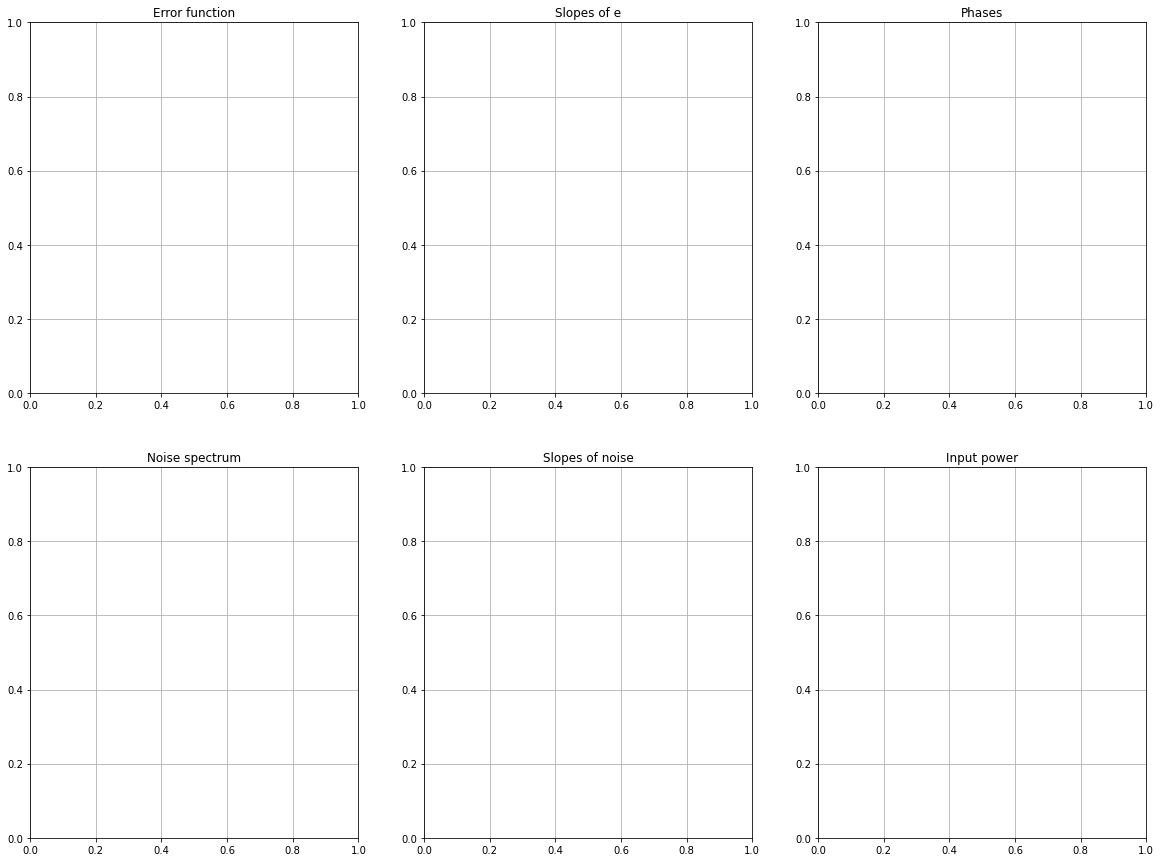

In [29]:
fig, ax = plt.subplots(2, 3, figsize=(20,15))
ax[0,0].set_title('Error function')
ax[0,1].set_title('Slopes of e')
ax[0,2].set_title('Phases')

ax[1,0].set_title('Noise spectrum')
ax[1,1].set_title('Slopes of noise')
ax[1,2].set_title('Input power')
ax[0,0].grid()
ax[0,1].grid()
ax[0,2].grid()
ax[1,0].grid()
ax[1,1].grid()
ax[1,2].grid()


now = datetime.now()  
folder = r'C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA\CoSi\Open_loop\error_func\with_TWPA'
file = r'XAndYErrFunc_'+ now.strftime(r'%H-%M-%S') + '.mat'
file_name = folder +'\\' + file

file_d = r'Y_ErrPsw_0to20_DUPLICATE_'+ now.strftime(r'%H-%M-%S') + '.mat'
file_name_d = folder +'\\' + file_d

# Attenuation
phase = np.linspace(0,355,72)  # Attenuation values. Seems like nothing to measure above 15 db

# Epsilon function
offset = 100
avg = 50 #50
nop = 201 
epsilon1 = np.empty((nop,len(phase)))
epsilon2 = np.empty((nop,len(phase)))
slope1 = np.empty((len(phase)))
amplitude1 = np.empty((len(phase)))
slope2 = np.empty((len(phase)))
amplitude2 = np.empty((len(phase)))

# Noise function
fft_avg = 100 # 300
fft_fr = dsa.get_freq()
err = np.empty((len(fft_fr),len(phase)))
slope_fft = np.empty((len(phase)))
amplitude_fft = np.empty((len(phase)))

gain = 10/(1000e-6)

# Input power 
XY = np.empty((len(phase)))

state=dict()
state['temp'] = 10
state['Gain'] = gain

state['phases'] = phase
state['epsilon1'] = epsilon1
state['epsilon2'] = epsilon2
state['slope_epsilon1'] = slope1
state['amplitude_epsilon1'] = amplitude1
state['slope_epsilon2'] = slope2
state['amplitude_epsilon2'] = amplitude2

state['anapico_pow'] = anapow
state['modulation_v'] = avg_volt
state['f_res4'] = f_res4

state['avg'] = avg
state['nop'] = nop
state['offset'] = offset

state['comment'] = 'CoSi 25 nm #4. X and Y component. TWPA on'

f_res = f_res4
anapico.set_freq(3, f_res*1e9)
# loking.set_phase(90)
print(datetime.now().strftime(r'%H-%M-%S:'), 'Phase', phase[i], 'db')

time.sleep(1) # wait until power would stabilize (at least 15 sec recommended)

#get total input power 
X0 = loking.get_X_data()
X0 = loking.get_X_data()
X0 = loking.get_X_data()
Y0 = loking.get_Y_data()
Y0 = loking.get_Y_data()
Y0 = loking.get_Y_data()
XY[i] = np.sqrt(X0**2+Y0**2)
state['XY'] = XY

# get epsilon sweep
freq_y, epsilon_mean1, epsilon_mean2, a, b, c, d = get_epsilon(offset,avg,nop,f_res) # ret error function and slope (a)
anapico.set_freq(3, f_res*1e9)

epsilon1[:,i] = epsilon_mean1
epsilon2[:,i] = epsilon_mean2

slope1[i] = a
amplitude1[i] = b
slope2[i] = c
amplitude2[i] = d

state['freq_y'] = freq_y
state['epsilon1'] = epsilon1
state['epsilon2'] = epsilon2
state['slope_epsilon1'] = slope1
state['amplitude_epsilon1'] = amplitude1
state['slope_epsilon2'] = slope2
state['amplitude_epsilon2'] = amplitude2

savemat(file_name, state)
savemat(file_name_d, state)
    
print(datetime.now().strftime(r'%H-%M-%S:'), 'Measurement done!')
    
ax[0,1].plot(np.arange(0,len(att_err)), np.log10(abs(slope/10)))
ax[0,2].plot(np.arange(0,len(att_err)), np.log10(abs(pha_sweep/10)))
ax[1,1].plot(np.arange(0,len(att_err)), np.log10(abs(slope_fft/10)))
ax[1,2].plot(np.arange(0,len(att_err)), np.log10(abs(XY/10)))
ax[0,0].legend()

In [86]:
loking.get_sensitivity()

10.0

In [75]:
loking.set_sensitivity(3)

Unable to read data from device.
 VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.
Check that device is connected, visible in NI MAX and is not used by another software.


'3: 3 μVrms / -97 dBm'

In [53]:
loking.set_auto_sens()

In [73]:
freq = np.linspace(2.1, 2.3, 51)
state=dict()
state['freq'] = freq

X = np.array([])
Y = np.array([])
for i in range(len(freq)):
    awg.write(r'SOUR{}:FREQ {}'.format(str(1), str(freq[i]*1e6)))
    loking.write('*CLS\n')
    loking.write('*CLS')
    loking.write('*CLS')
    time.sleep(0.5)
    x0 = loking.get_X_data()
    x1 = loking.get_X_data()
    x2 = loking.get_X_data()
    x0 = loking.get_X_data()
    x1 = loking.get_X_data()
    x2 = loking.get_X_data()
    x0 = loking.get_X_data()
    x1 = loking.get_X_data()
    x2 = loking.get_X_data()
    x2 = loking.get_X_data()
    x0 = loking.get_X_data()
    x1 = loking.get_X_data()
    x2 = loking.get_X_data()
    X = np.append(X, loking.get_X_data())
    loking.write('*CLS\n')
    loking.write('*CLS')
    x0 = loking.get_Y_data()
    x1 = loking.get_Y_data()
    x2 = loking.get_Y_data()
    x0 = loking.get_Y_data()
    x1 = loking.get_Y_data()
    x2 = loking.get_Y_data()
    x0 = loking.get_Y_data()
    x1 = loking.get_Y_data()
    x2 = loking.get_Y_data()
    x1 = loking.get_Y_data()
    x2 = loking.get_Y_data()
    x0 = loking.get_Y_data()
    x1 = loking.get_Y_data()
    x2 = loking.get_Y_data()
    Y = np.append(Y, loking.get_Y_data())
state['X'] = X
state['Y'] = Y

now = datetime.now()  
folder = r'C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA\CoSi2_25nm_Shield'
# file = r'ModulationFTest_'+ now.strftime(r'%H-%M-%S') + '.mat'
file = now.strftime(r'%Y%m%d%H%M%S') + r'_Poundlock_Fm'+ '.mat'
file_name = folder +'\\' + file
savemat(file_name, state)

In [74]:
awg.write(r'SOUR{}:FREQ {}'.format(str(1), str(2.192*1e6)))

22